# Cryptocurrency return prediction with historical intraday pricing data


---


This notebook provides a simple demonstration for the last question on problem set 4. It is not meant to be a "model answer". Indeed, we are only going to try out a small number of candidate models with a small subset of the available data. Nonetheless, hopefully the ideas below will give you some indications of what paths we can take when approaching such a prediction problem.


Load some packages to be used in the program, as usual.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

Read the csv file using the link provided in Moodle which contains the historical intraday pricing data of Monero.

In [ ]:
filepath = 'https://www.dropbox.com/s/3eonftnxrvpmy68/monero.csv?dl=1'
data = pd.read_csv(filepath) # read the csv file

display(data) # take a look of the raw data file

,timestamp,Count,Open,High,Low,Close,Volume,VWAP
0,1514764860,7.0,329.0900,329.88,329.09,329.4600,6.635710,329.454118
1,1514764920,1.0,329.4500,329.45,329.45,329.4500,0.349420,329.450000
2,1514764980,3.0,329.2700,329.27,329.19,329.1900,1.189553,329.198979
3,1514765040,2.0,328.1600,328.16,328.16,328.1600,1.512079,328.160000
4,1514765100,7.0,328.1800,328.18,327.43,327.4300,11.997972,328.077776
...,...,...,...,...,...,...,...,...
1701256,1632182160,55.0,232.3550,232.66,231.75,231.9900,114.310820,232.001151
1701257,1632182220,42.0,231.6260,231.92,231.10,231.2800,19.751763,231.437555
1701258,1632182280,48.0,231.1925,231.70,231.06,231.1525,123.418300,231.261961
1701259,1632182340,72.0,231.4660,232.79,231.10,232.2580,115.242365,231.955915


# Data inspection, modification and cleaning

In the raw file, the values in the timestamp column are stated in the so called "Unix timestamp format" which is a string of digits representing the number of seconds between the current time and 00:00:00 on 1 January 1970 UTC time. We can first transform the values in this column to the more intuitive date-time format.

In [ ]:
from datetime import datetime
data['timestamp'] = pd.to_datetime(data['timestamp'], unit='s')
display(data)

,timestamp,Count,Open,High,Low,Close,Volume,VWAP
0,2018-01-01 00:01:00,7.0,329.0900,329.88,329.09,329.4600,6.635710,329.454118
1,2018-01-01 00:02:00,1.0,329.4500,329.45,329.45,329.4500,0.349420,329.450000
2,2018-01-01 00:03:00,3.0,329.2700,329.27,329.19,329.1900,1.189553,329.198979
3,2018-01-01 00:04:00,2.0,328.1600,328.16,328.16,328.1600,1.512079,328.160000
4,2018-01-01 00:05:00,7.0,328.1800,328.18,327.43,327.4300,11.997972,328.077776
...,...,...,...,...,...,...,...,...
1701256,2021-09-20 23:56:00,55.0,232.3550,232.66,231.75,231.9900,114.310820,232.001151
1701257,2021-09-20 23:57:00,42.0,231.6260,231.92,231.10,231.2800,19.751763,231.437555
1701258,2021-09-20 23:58:00,48.0,231.1925,231.70,231.06,231.1525,123.418300,231.261961
1701259,2021-09-20 23:59:00,72.0,231.4660,232.79,231.10,232.2580,115.242365,231.955915


Now we can check if there are any missing values in the file.

In [ ]:
print('Number of missing data: ',  data.isnull().sum())
print('Memory Usage: {} MB'.format(data.memory_usage().sum()/(1024**2)))

Number of missing data:  timestamp    0
Count        0
Open         0
High         0
Low          0
Close        0
Volume       0
VWAP         0
dtype: int64
Memory Usage: 103.83685302734375 MB


Let's take a look at the time series of the closing price, which has been rather volatile over the 3.5 years horizon.

(array([736695., 736876., 737060., 737241., 737425., 737607., 737791.,
        737972.]), <a list of 8 Text major ticklabel objects>)

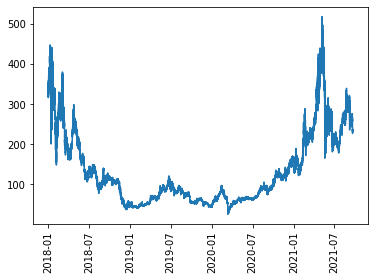

In [ ]:
plt.plot(data['timestamp'], data['Close'])
plt.xticks(rotation=90)

Now we create a column "Ret(t-1,t)" which contains the rate of return between the current time and one minute ago. Then we shift this column and create another new column "Ret(t,t+1)", which is our target label corresponding to the return over the next one minute. Note that we multiple the rate of return by $100\times 24\times 60$ and hence the return value roughly has the same scale as the percentage daily return (and empirically, daily returns of many financial assets have mean values of 1% in order of magnitude).

Another alternative is simply to ask the model to predict the change in the price (rather than looking at the percentage change). Then, if we want, we can compute the percentage change prediction by dividing the predicted price change by the current closing price. In the demo below, we will use this approach where the model training with this definition of label seems to be a bit more stable.

In [ ]:
# percentage return definition
#data['Ret(t-1,t)'] = (data['Close'].diff(1)) / data['Close'] * 100 * 24 * 60 

# net price diff definition
data['Ret(t-1,t)'] = (data['Close'].diff(1)) 

data['Ret(t,t+1)'] = data['Ret(t-1,t)'] .shift(-1)

By default, we are given 7 time series in the raw data. But if we believe there is additional information that could help with the prediction, we could handcraft some new features (channels) using the raw data. For example, "High Price minus Low Price" can capture the price fluctuation within the one-minute interval; "Close minus Low" reflects the degree of intra-interval price reversal, etc.

To capture such information, we manually introduce three new columns: "Close minus High", "Close minus Low" and "High minus Low". Of course, in theory the neural network should be able to capture these factors if they turn out to be useful. But the advantage of explicitly including them as the column features (channels) is that we are guiding the model to look at the influence of these variables.

Feel free to be creative and throw in extra features that you believe useful!

In [ ]:
data['Close minus High'] = data['Close'] - data['High']
data['Close minus Low'] = data['Close'] - data['Low']
data['High minus Low'] = data['High'] - data['Low']

In [ ]:
data = data.dropna()
display(data)

,timestamp,Count,Open,High,Low,Close,Volume,VWAP,"Ret(t-1,t)","Ret(t,t+1)",Close minus High,Close minus Low,High minus Low
1,2018-01-01 00:02:00,1.0,329.4500,329.45,329.45,329.4500,0.349420,329.450000,-0.0100,-0.2600,0.0000,0.0000,0.00
2,2018-01-01 00:03:00,3.0,329.2700,329.27,329.19,329.1900,1.189553,329.198979,-0.2600,-1.0300,-0.0800,0.0000,0.08
3,2018-01-01 00:04:00,2.0,328.1600,328.16,328.16,328.1600,1.512079,328.160000,-1.0300,-0.7300,0.0000,0.0000,0.00
4,2018-01-01 00:05:00,7.0,328.1800,328.18,327.43,327.4300,11.997972,328.077776,-0.7300,4.5100,-0.7500,0.0000,0.75
5,2018-01-01 00:06:00,9.0,332.0000,336.56,327.10,331.9400,2.291827,331.898785,4.5100,-5.0300,-4.6200,4.8400,9.46
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1701255,2021-09-20 23:55:00,36.0,232.6425,232.80,232.23,232.6325,40.664090,232.585522,-0.0750,-0.6425,-0.1675,0.4025,0.57
1701256,2021-09-20 23:56:00,55.0,232.3550,232.66,231.75,231.9900,114.310820,232.001151,-0.6425,-0.7100,-0.6700,0.2400,0.91
1701257,2021-09-20 23:57:00,42.0,231.6260,231.92,231.10,231.2800,19.751763,231.437555,-0.7100,-0.1275,-0.6400,0.1800,0.82
1701258,2021-09-20 23:58:00,48.0,231.1925,231.70,231.06,231.1525,123.418300,231.261961,-0.1275,1.1055,-0.5475,0.0925,0.64


We can look at the summary statistics of the data as follow.

In [ ]:
data.describe()

,Count,Open,High,Low,Close,Volume,VWAP,"Ret(t-1,t)","Ret(t,t+1)",Close minus High,Close minus Low,High minus Low
count,1.701259e+06,1.701259e+06,1.701259e+06,1.701259e+06,1.701259e+06,1.701259e+06,1.701259e+06,1.701259e+06,1.701259e+06,1.701259e+06,1.701259e+06,1.701259e+06
mean,3.480303e+01,1.360710e+02,1.363020e+02,1.358390e+02,1.360708e+02,9.510358e+01,1.360693e+02,-5.713533e-05,-5.711946e-05,-2.311915e-01,2.318728e-01,4.630643e-01
std,1.045905e+02,9.444922e+01,9.462822e+01,9.426323e+01,9.444854e+01,2.424277e+02,9.444689e+01,5.254263e-01,5.254263e-01,5.679461e-01,5.278825e-01,1.030940e+00
min,1.000000e+00,2.588625e+01,2.670000e+01,1.000000e-02,2.580575e+01,1.000000e-08,2.589617e+01,-2.026400e+02,-2.026400e+02,-2.036900e+02,-1.421085e-14,0.000000e+00
25%,4.000000e+00,6.424000e+01,6.431050e+01,6.417000e+01,6.424000e+01,5.612888e+00,6.424000e+01,-8.500000e-02,-8.500000e-02,-2.500000e-01,1.500000e-02,5.000000e-02
50%,1.100000e+01,9.423500e+01,9.434000e+01,9.411000e+01,9.423000e+01,2.767243e+01,9.423051e+01,0.000000e+00,0.000000e+00,-8.333333e-02,8.500000e-02,1.830000e-01
75%,3.200000e+01,2.024367e+02,2.027400e+02,2.021500e+02,2.024400e+02,9.459531e+01,2.024361e+02,8.750000e-02,8.750000e-02,-1.500000e-02,2.550000e-01,5.200000e-01
max,1.404500e+04,5.173020e+02,5.193000e+02,5.153500e+02,5.177000e+02,2.062070e+04,5.173082e+02,2.023500e+02,2.023500e+02,7.105427e-15,2.006900e+02,4.043800e+02


One thing which is a bit strange is that the minimum value of the "Low" column is 0.01 which does not look quite right. Let's try to pin down which rows in the data are having such a small value of "Low".

In [ ]:
display(data[data['Low']<10]) # display all rows with Low value < 10

,timestamp,Count,Open,High,Low,Close,Volume,VWAP,"Ret(t-1,t)","Ret(t,t+1)",Close minus High,Close minus Low,High minus Low
16709,2018-01-13 11:23:00,32.0,202.2,404.39,0.01,200.7,132.06621,201.090392,-202.64,202.35,-203.69,200.69,404.38


There is one line of the data at time "2018-01-13 11:23:00" giving this strange value of Low while the other entries seem to be okay. Probably it won't matter much but we can drop this row of the data as follows.

In [ ]:
data = data.drop(data[data['Low']<10].index)
data.describe()

,Count,Open,High,Low,Close,Volume,VWAP,"Ret(t-1,t)","Ret(t,t+1)",Close minus High,Close minus Low,High minus Low
count,1.701258e+06,1.701258e+06,1.701258e+06,1.701258e+06,1.701258e+06,1.701258e+06,1.701258e+06,1.701258e+06,1.701258e+06,1.701258e+06,1.701258e+06,1.701258e+06
mean,3.480303e+01,1.360710e+02,1.363019e+02,1.358391e+02,1.360708e+02,9.510356e+01,1.360693e+02,6.197649e-05,-1.760609e-04,-2.310719e-01,2.317550e-01,4.628268e-01
std,1.045905e+02,9.444924e+01,9.462802e+01,9.426320e+01,9.444855e+01,2.424278e+02,9.444691e+01,5.019324e-01,5.020011e-01,5.461050e-01,5.050151e-01,9.833306e-01
min,1.000000e+00,2.588625e+01,2.670000e+01,2.508000e+01,2.580575e+01,1.000000e-08,2.589617e+01,-5.428000e+01,-2.026400e+02,-1.115850e+02,-1.421085e-14,0.000000e+00
25%,4.000000e+00,6.424000e+01,6.431025e+01,6.417000e+01,6.424000e+01,5.612884e+00,6.424000e+01,-8.500000e-02,-8.500000e-02,-2.500000e-01,1.500000e-02,5.000000e-02
50%,1.100000e+01,9.423500e+01,9.434000e+01,9.411000e+01,9.423000e+01,2.767238e+01,9.423046e+01,0.000000e+00,0.000000e+00,-8.333333e-02,8.500000e-02,1.830000e-01
75%,3.200000e+01,2.024367e+02,2.027400e+02,2.021500e+02,2.024400e+02,9.459523e+01,2.024362e+02,8.750000e-02,8.750000e-02,-1.500000e-02,2.550000e-01,5.200000e-01
max,1.404500e+04,5.173020e+02,5.193000e+02,5.153500e+02,5.177000e+02,2.062070e+04,5.173082e+02,2.023500e+02,4.983000e+01,7.105427e-15,8.390600e+01,1.339300e+02


Now the minimum value of "Low" looks better now!

# Splitting the data and cross-validation

One problem here is that our data set is somewhat a large one with more than 1.7 million data points. When we develop the framework of a deep learning program, it is useful to just test our code with a smaller subset of the data. This is to avoid situations such as we have spent more than 24 hours to train the model just to find out that there are coding errors at the end and the results cannot be used. 

Other reason is that if we run this notebook on Colab with the full dataset, there is a risk of consuming all the available RAM due to the heavy data handling and in turn the whole session will crash. Hence for any large-scale machine learning problem, you may need to run it on your local computer rather than on Colab (but still you can test your code with a smaller dataset on Colab first before running the program with the full dataset locally on your own computer).


In this example, we only use a subset of the original data which just contains 100000 data points. The follow segment of code can be commented out later if we want to use the entire data set.

In [ ]:
#comment this part out if you want to use the entire dataset

data = data.tail(100000) # trim down data by only retaining the last 100,000 rows of data.
data = data.reset_index(drop=True) # reset the row index after trimming down the data
display(data)

,timestamp,Count,Open,High,Low,Close,Volume,VWAP,"Ret(t-1,t)","Ret(t,t+1)",Close minus High,Close minus Low,High minus Low
0,2021-07-13 12:46:00,11.0,204.4550,204.50,204.35,204.4050,7.236560,204.453969,-0.0600,0.4850,-0.0950,0.0550,0.15
1,2021-07-13 12:47:00,61.0,204.5075,205.11,204.41,204.8900,144.916291,204.693498,0.4850,0.1100,-0.2200,0.4800,0.70
2,2021-07-13 12:48:00,53.0,205.0250,205.28,204.87,205.0000,75.084310,205.040776,0.1100,-0.2200,-0.2800,0.1300,0.41
3,2021-07-13 12:49:00,15.0,205.0100,205.01,204.78,204.7800,22.823820,204.944942,-0.2200,-0.0750,-0.2300,0.0000,0.23
4,2021-07-13 12:50:00,12.0,204.8450,204.89,204.67,204.7050,33.202170,204.731390,-0.0750,-0.2450,-0.1850,0.0350,0.22
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,2021-09-20 23:55:00,36.0,232.6425,232.80,232.23,232.6325,40.664090,232.585522,-0.0750,-0.6425,-0.1675,0.4025,0.57
99996,2021-09-20 23:56:00,55.0,232.3550,232.66,231.75,231.9900,114.310820,232.001151,-0.6425,-0.7100,-0.6700,0.2400,0.91
99997,2021-09-20 23:57:00,42.0,231.6260,231.92,231.10,231.2800,19.751763,231.437555,-0.7100,-0.1275,-0.6400,0.1800,0.82
99998,2021-09-20 23:58:00,48.0,231.1925,231.70,231.06,231.1525,123.418300,231.261961,-0.1275,1.1055,-0.5475,0.0925,0.64


We are going to try out the idea of cross-validation as covered in Topic 2. The principle here is that we split the time series data into multiple folds based on chronological order. We first train the model with fold 1 and validate the model with fold 2 and compute a validation score. Then we train the model with fold 1 and fold 2, and validate the model with fold 3 and compute a validation score. We continue until the last fold is used for validation.

We repeat the above procedures for different combination of candidate models and other hyperparameters. The setup yielding the highest average validation score is considered as the best one.

(Remark: there are many other alternatives regarding how the cross-validation is performed)

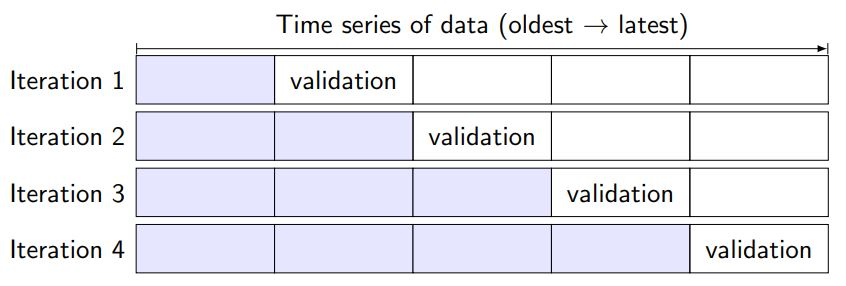

While it is not hard to code the split of the data into different folds by hands, the "TimeSeriesSplit" function from the "sklearn" library can help us with this task. Essentially, this function can return different arrays of indices which allow us to mark the row numbers of the dataframe that are used as the training and validation sets respectively in each iteration.

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

NUM_FOLD = 4   # the number of folds we use

tscv = TimeSeriesSplit(n_splits=NUM_FOLD - 1) # with 4 folds there will then be 3 iterations

# let's take a look at what this object does
for train_index, valid_index in tscv.split(data):
    print("Training indices:", train_index, "Validation indices:", valid_index)

Training indices: [    0     1     2 ... 24997 24998 24999] Validation indices: [25000 25001 25002 ... 49997 49998 49999]
Training indices: [    0     1     2 ... 49997 49998 49999] Validation indices: [50000 50001 50002 ... 74997 74998 74999]
Training indices: [    0     1     2 ... 74997 74998 74999] Validation indices: [75000 75001 75002 ... 99997 99998 99999]


As a result, we can create different folds of training data and validation data as follows (via creating two lists of pandas dataframe where each element in the list contains the training/validation set for one fold).

In [ ]:
train_block = []
valid_block = []

for train_index, valid_index in tscv.split(data):

    this_train = data.loc[train_index]
    this_train = this_train.reset_index(drop=True)

    this_valid = data.loc[valid_index]
    this_valid = this_valid.reset_index(drop=True)

    train_block.append(this_train)
    valid_block.append(this_valid)

del data

We can take a look at what we have created by iterating through the lists.

In [ ]:
for i in range (NUM_FOLD - 1):
    print("Data for Iteration {}".format(i+1))
    display(train_block[i])
    display(valid_block[i])

Data for Iteration 1


,timestamp,Count,Open,High,Low,Close,Volume,VWAP,"Ret(t-1,t)","Ret(t,t+1)",Close minus High,Close minus Low,High minus Low
0,2021-07-13 12:46:00,11.0,204.455000,204.50,204.35,204.405000,7.236560,204.453969,-0.060000,0.485000,-0.095000,0.055000,0.15
1,2021-07-13 12:47:00,61.0,204.507500,205.11,204.41,204.890000,144.916291,204.693498,0.485000,0.110000,-0.220000,0.480000,0.70
2,2021-07-13 12:48:00,53.0,205.025000,205.28,204.87,205.000000,75.084310,205.040776,0.110000,-0.220000,-0.280000,0.130000,0.41
3,2021-07-13 12:49:00,15.0,205.010000,205.01,204.78,204.780000,22.823820,204.944942,-0.220000,-0.075000,-0.230000,0.000000,0.23
4,2021-07-13 12:50:00,12.0,204.845000,204.89,204.67,204.705000,33.202170,204.731390,-0.075000,-0.245000,-0.185000,0.035000,0.22
...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,2021-07-30 21:43:00,26.0,240.846667,241.13,240.80,240.983333,11.168830,240.868080,-0.010000,0.096667,-0.146667,0.183333,0.33
24996,2021-07-30 21:44:00,38.0,241.060000,241.29,240.92,241.080000,63.102754,241.101918,0.096667,0.202500,-0.210000,0.160000,0.37
24997,2021-07-30 21:45:00,35.0,241.230000,241.38,241.10,241.282500,45.466310,241.254456,0.202500,-0.022500,-0.097500,0.182500,0.28
24998,2021-07-30 21:46:00,20.0,241.280000,241.38,241.16,241.260000,22.119750,241.261461,-0.022500,-0.013333,-0.120000,0.100000,0.22


,timestamp,Count,Open,High,Low,Close,Volume,VWAP,"Ret(t-1,t)","Ret(t,t+1)",Close minus High,Close minus Low,High minus Low
0,2021-07-30 21:48:00,43.0,241.355000,241.55,241.22,241.490000,54.492690,241.393659,0.243333,-0.032500,-0.060000,0.270000,0.33
1,2021-07-30 21:49:00,54.0,241.557500,241.73,241.23,241.457500,39.464155,241.394025,-0.032500,0.067500,-0.272500,0.227500,0.50
2,2021-07-30 21:50:00,28.0,241.410000,241.65,241.39,241.525000,30.574740,241.546194,0.067500,-0.789000,-0.125000,0.135000,0.26
3,2021-07-30 21:51:00,158.0,241.342000,241.55,240.27,240.736000,231.263921,240.996324,-0.789000,-0.703500,-0.814000,0.466000,1.28
4,2021-07-30 21:52:00,74.0,240.597500,240.85,239.78,240.032500,149.381157,240.338961,-0.703500,-0.355000,-0.817500,0.252500,1.07
...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,2021-08-17 06:26:00,19.0,269.400000,269.53,269.38,269.405000,37.837280,269.420352,-0.095000,0.148333,-0.125000,0.025000,0.15
24996,2021-08-17 06:27:00,26.0,269.610000,269.78,269.24,269.553333,32.224260,269.635255,0.148333,0.326667,-0.226667,0.313333,0.54
24997,2021-08-17 06:28:00,33.0,269.672500,270.21,269.53,269.880000,55.511968,269.830728,0.326667,0.236000,-0.330000,0.350000,0.68
24998,2021-08-17 06:29:00,31.0,270.046000,270.29,269.84,270.116000,18.481767,270.072241,0.236000,-0.092667,-0.174000,0.276000,0.45


Data for Iteration 2


,timestamp,Count,Open,High,Low,Close,Volume,VWAP,"Ret(t-1,t)","Ret(t,t+1)",Close minus High,Close minus Low,High minus Low
0,2021-07-13 12:46:00,11.0,204.455000,204.50,204.35,204.405000,7.236560,204.453969,-0.060000,0.485000,-0.095000,0.055000,0.15
1,2021-07-13 12:47:00,61.0,204.507500,205.11,204.41,204.890000,144.916291,204.693498,0.485000,0.110000,-0.220000,0.480000,0.70
2,2021-07-13 12:48:00,53.0,205.025000,205.28,204.87,205.000000,75.084310,205.040776,0.110000,-0.220000,-0.280000,0.130000,0.41
3,2021-07-13 12:49:00,15.0,205.010000,205.01,204.78,204.780000,22.823820,204.944942,-0.220000,-0.075000,-0.230000,0.000000,0.23
4,2021-07-13 12:50:00,12.0,204.845000,204.89,204.67,204.705000,33.202170,204.731390,-0.075000,-0.245000,-0.185000,0.035000,0.22
...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,2021-08-17 06:26:00,19.0,269.400000,269.53,269.38,269.405000,37.837280,269.420352,-0.095000,0.148333,-0.125000,0.025000,0.15
49996,2021-08-17 06:27:00,26.0,269.610000,269.78,269.24,269.553333,32.224260,269.635255,0.148333,0.326667,-0.226667,0.313333,0.54
49997,2021-08-17 06:28:00,33.0,269.672500,270.21,269.53,269.880000,55.511968,269.830728,0.326667,0.236000,-0.330000,0.350000,0.68
49998,2021-08-17 06:29:00,31.0,270.046000,270.29,269.84,270.116000,18.481767,270.072241,0.236000,-0.092667,-0.174000,0.276000,0.45


,timestamp,Count,Open,High,Low,Close,Volume,VWAP,"Ret(t-1,t)","Ret(t,t+1)",Close minus High,Close minus Low,High minus Low
0,2021-08-17 06:31:00,21.0,270.190000,270.28,269.80,269.865000,9.351381,270.054933,-0.158333,-0.275000,-0.415000,0.065000,0.48
1,2021-08-17 06:32:00,20.0,269.765000,269.85,269.33,269.590000,12.092620,269.589758,-0.275000,-0.156667,-0.260000,0.260000,0.52
2,2021-08-17 06:33:00,18.0,269.493333,269.53,269.35,269.433333,9.308290,269.469019,-0.156667,-0.208333,-0.096667,0.083333,0.18
3,2021-08-17 06:34:00,8.0,269.305000,269.33,269.17,269.225000,3.730930,269.277890,-0.208333,-0.120000,-0.105000,0.055000,0.16
4,2021-08-17 06:35:00,47.0,269.105000,269.55,268.91,269.105000,45.151510,269.184760,-0.120000,-0.360000,-0.445000,0.195000,0.64
...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,2021-09-03 15:09:00,552.0,308.296000,309.70,308.10,309.024000,894.393971,308.907410,1.044000,-0.041500,-0.676000,0.924000,1.60
24996,2021-09-03 15:10:00,126.0,309.017500,309.50,308.50,308.982500,249.279894,309.095972,-0.041500,0.250000,-0.517500,0.482500,1.00
24997,2021-09-03 15:11:00,62.0,308.955000,309.43,308.69,309.232500,91.449780,309.084694,0.250000,-0.012500,-0.197500,0.542500,0.74
24998,2021-09-03 15:12:00,55.0,309.280000,309.54,309.13,309.220000,138.274254,309.389195,-0.012500,-0.510000,-0.320000,0.090000,0.41


Data for Iteration 3


,timestamp,Count,Open,High,Low,Close,Volume,VWAP,"Ret(t-1,t)","Ret(t,t+1)",Close minus High,Close minus Low,High minus Low
0,2021-07-13 12:46:00,11.0,204.4550,204.50,204.35,204.4050,7.236560,204.453969,-0.0600,0.485000,-0.0950,0.0550,0.15
1,2021-07-13 12:47:00,61.0,204.5075,205.11,204.41,204.8900,144.916291,204.693498,0.4850,0.110000,-0.2200,0.4800,0.70
2,2021-07-13 12:48:00,53.0,205.0250,205.28,204.87,205.0000,75.084310,205.040776,0.1100,-0.220000,-0.2800,0.1300,0.41
3,2021-07-13 12:49:00,15.0,205.0100,205.01,204.78,204.7800,22.823820,204.944942,-0.2200,-0.075000,-0.2300,0.0000,0.23
4,2021-07-13 12:50:00,12.0,204.8450,204.89,204.67,204.7050,33.202170,204.731390,-0.0750,-0.245000,-0.1850,0.0350,0.22
...,...,...,...,...,...,...,...,...,...,...,...,...,...
74995,2021-09-03 15:09:00,552.0,308.2960,309.70,308.10,309.0240,894.393971,308.907410,1.0440,-0.041500,-0.6760,0.9240,1.60
74996,2021-09-03 15:10:00,126.0,309.0175,309.50,308.50,308.9825,249.279894,309.095972,-0.0415,0.250000,-0.5175,0.4825,1.00
74997,2021-09-03 15:11:00,62.0,308.9550,309.43,308.69,309.2325,91.449780,309.084694,0.2500,-0.012500,-0.1975,0.5425,0.74
74998,2021-09-03 15:12:00,55.0,309.2800,309.54,309.13,309.2200,138.274254,309.389195,-0.0125,-0.510000,-0.3200,0.0900,0.41


,timestamp,Count,Open,High,Low,Close,Volume,VWAP,"Ret(t-1,t)","Ret(t,t+1)",Close minus High,Close minus Low,High minus Low
0,2021-09-03 15:14:00,43.0,308.953333,309.23,308.60,309.013333,46.145672,309.033779,0.303333,0.101667,-0.216667,0.413333,0.63
1,2021-09-03 15:15:00,61.0,309.060000,309.34,308.68,309.115000,85.388374,309.073233,0.101667,-0.337500,-0.225000,0.435000,0.66
2,2021-09-03 15:16:00,51.0,308.972500,309.03,308.60,308.777500,213.783826,308.882756,-0.337500,0.134500,-0.252500,0.177500,0.43
3,2021-09-03 15:17:00,34.0,308.978000,309.24,308.70,308.912000,152.565341,308.949877,0.134500,0.128000,-0.328000,0.212000,0.54
4,2021-09-03 15:18:00,32.0,308.780000,309.19,308.59,309.040000,16.148040,308.882303,0.128000,0.002500,-0.150000,0.450000,0.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,2021-09-20 23:55:00,36.0,232.642500,232.80,232.23,232.632500,40.664090,232.585522,-0.075000,-0.642500,-0.167500,0.402500,0.57
24996,2021-09-20 23:56:00,55.0,232.355000,232.66,231.75,231.990000,114.310820,232.001151,-0.642500,-0.710000,-0.670000,0.240000,0.91
24997,2021-09-20 23:57:00,42.0,231.626000,231.92,231.10,231.280000,19.751763,231.437555,-0.710000,-0.127500,-0.640000,0.180000,0.82
24998,2021-09-20 23:58:00,48.0,231.192500,231.70,231.06,231.152500,123.418300,231.261961,-0.127500,1.105500,-0.547500,0.092500,0.64


Finally, collect the list of features that we want to use for the prediction and specify the target label that we want to predict.

In [ ]:
list_of_features = ['Count',	'Open',	'High',	'Low',	'Close',	'Volume',	'VWAP',	'Ret(t-1,t)', 'Close minus High',	'Close minus Low',	'High minus Low']
target_label = 'Ret(t,t+1)'

# The training function

It is convenient to wrap the model training part in form of a function since we need to perform the training multiple times. 

This function will take in the training dataframe, validation dataframe, the window of historical data to be used, a list of strings containing what features to be used, a string representing what column is the label, and the optional arguments for epochs and batch size during training. The output is the training history and the loss function value evaluated against the validation data.

The implementation below is based on NB 4.3. This involves scaling the features, reshaping the data (so it can be passed to a convolutional neural network) and then training the model.

In [ ]:
def train_model_once(train, valid, the_model, window, the_features, the_label, num_epochs=10, num_batch_size=32):

      train_data = train
      valid_data = valid

      # Scale the features
      train_mean = train_data[the_features].mean()
      train_std = train_data[the_features].std()

      train_data[the_features]= (train_data[the_features] - train_mean) / train_std
      valid_data[the_features] = (valid_data[the_features] - train_mean) / train_std

      # Structure the training data
      x_train, y_train = [], []
      for t in range(train_data.shape[0]):

          if t % 5000 == 0:
              print("Training data processing: {} of {} done".format(t, train_data.shape[0])) 

          if t + window > train_data.shape[0]:
              break
              
          x_train.append(train_data.loc[t : t + window - 1, the_features])
          y_train.append(train_data.loc[t + window - 1, the_label]) 

      x_train = np.array(x_train)
      y_train = np.array(y_train)

      del train_data

      # Structure the validation data
      x_valid, y_valid = [], []
      for t in range(valid_data.shape[0]):

          if t % 5000 == 0:
              print("Validation data processing: {} of {} done".format(t, valid_data.shape[0])) 

          if t + window > valid_data.shape[0]:
              break
              
          x_valid.append(valid_data.loc[t : t + window - 1, the_features])
          y_valid.append(valid_data.loc[t + window - 1, the_label]) 

      x_valid = np.array(x_valid)
      y_valid = np.array(y_valid)

      del valid_data

      # train the model
      train_result = the_model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(x_valid,y_valid))

      # compute the validation loss
      lossval = the_model.evaluate(x_valid, y_valid, verbose=0)

      return train_result, lossval

# A family of candidate models

Next, we define two python functions which will generate a class of (somewhat generic) FNNs and CNNs.

For the FNN, we can choose the number of hidden layers, number of neurons, the activation function at the hidden layers and whether batch normalisation is used.

For the CNN, we can choose the number of convolutional layers, the initial number of filters and their common length per convolutional layer, the number of FNN layers at the end, the activation function at hidden layers and whether batch normalisation is used. We let the number of filters grow by a factor of two as we propagate through the convolutional layers, but cap the number by an upper limit. 

(Of course, there is lot of room to make these two functions even more generic.)

In [ ]:
# The first model class is a feedforward neural network (FNN)
def CreateFNNModel(window, num_channel, num_neuron, num_hidden_layer, actfun='relu', batch_norm=False):

    model = tf.keras.models.Sequential()

    # By default we reshape all our data as a matrix (window width times number of channels).
    # If we want to use the FNN model which expects the input as a vector rather than matrix, we can use Flatten() at the input layer
    model.add(tf.keras.layers.Flatten(input_shape=(window,num_channel)))

    for i in range(num_hidden_layer):
        model.add(tf.keras.layers.Dense(num_neuron))
        if batch_norm:
            model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Activation(actfun))

    model.add(tf.keras.layers.Dense(1, activation='linear'))

    return model


# The second model class is a convolutional neural network (CNN)
def CreateCNNModel(window, num_channel, ini_num_filter, filter_length, num_cnn_layer, num_fnn_layer, num_fnn_neurons, max_filter=512, actfun='relu', batch_norm=False):

    model = tf.keras.models.Sequential()

    num_filter = ini_num_filter

    model.add(tf.keras.layers.Conv1D(filters=num_filter,kernel_size=filter_length, strides=1, padding="SAME", input_shape=(window,len(list_of_features))))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation(actfun))


    for i in range(num_cnn_layer):

        num_filter = np.minimum(2*num_filter, max_filter)

        model.add(tf.keras.layers.Conv1D(filters=num_filter,kernel_size=filter_length, strides=1, padding="SAME"))
        if batch_norm:
            model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Activation(actfun))


    model.add(tf.keras.layers.GlobalAveragePooling1D())

    for i in range(num_fnn_layer):
        model.add(tf.keras.layers.Dense(num_fnn_neurons))
        if batch_norm:
            model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Activation(actfun))

    model.add(tf.keras.layers.Dense(1, activation='linear'))

    return model

# Define and compile our candidate models

We will only consider two setups for simplicity. In the first setup, we will use a window of 30 observations and a FNN model. In the second setup, we will use a window of 60 observations and a CNN model. 

In [ ]:
# Define the candidate models and setup
list_of_window = [30, 60]
model0 = CreateFNNModel(list_of_window[0], len(list_of_features), 512, 10, actfun='relu', batch_norm=True)
model1 = CreateCNNModel(list_of_window[1], len(list_of_features), 32, 3, 5, 5, 256, max_filter=1024, actfun='relu', batch_norm=True)


# Compile the candidate models
model0.compile(optimizer=tf.keras.optimizers.Adam(0.01), loss='mean_squared_error') 
model1.compile(optimizer=tf.keras.optimizers.Adam(0.01), loss='mean_squared_error')

# Collect the compiled model in a list
list_of_model = [model0, model1]

# Look at the models' structures
for model in list_of_model:
    model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 330)               0         
                                                                 
 dense (Dense)               (None, 512)               169472    
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2048      
 hNormalization)                                        

# Perform the cross-validation

Now we perform the cross-validation by performing a double loop. In the outer loop, we loop through each candidate model. In the inner loop, we loop through each fold to compute the validation score for each iteration. The average validation score is computed for each candidate model.

Note that a good practice is to reset the model parameters after completion of each iteration so the previous training results will not influence the training for the next iteration. There does not seem to be a clean function within TensorFlow to reset the model parameters, so we will use "model.get_weights()" and "model.set_weights()" to manually reset the model parameters before initiating a new training.

In [ ]:
EPOCHS = 10
BATCH_SIZE = 64

all_avg_loss = []
ep = range(EPOCHS)

for j, model in enumerate(list_of_model):

    ini_weight = model.get_weights()  

    total_loss = 0

    for i in range (NUM_FOLD - 1):

        print("Current iteration of cross-validation: {} of {}".format(i+1, NUM_FOLD-1))

        model.set_weights(ini_weight)

        train_data = train_block[i]
        valid_data = valid_block[i]

        r, this_loss = train_model_once(train_data, valid_data, model, list_of_window[j], list_of_features, target_label, EPOCHS, BATCH_SIZE)

        # Can un-comment the below to show the plot of training and validation losses

        #fig,ax = plt.subplots()
        #ax.plot(ep, r.history['loss'], 'r--')
        #ax.set_xlabel("epochs")
        #ax.set_ylabel("training loss",color="red")
        #ax2=ax.twinx()
        #ax2.plot(ep, r.history['val_loss'],'b--')
        #ax2.set_ylabel("validation loss",color="blue")
        #plt.show()

        total_loss = total_loss + this_loss

    all_avg_loss.append(total_loss / (NUM_FOLD - 1))

Current iteration of cross-validation: 1 of 3
Training data processing: 0 of 25000 done
Training data processing: 5000 of 25000 done
Training data processing: 10000 of 25000 done
Training data processing: 15000 of 25000 done
Training data processing: 20000 of 25000 done
Validation data processing: 0 of 25000 done
Validation data processing: 5000 of 25000 done
Validation data processing: 10000 of 25000 done
Validation data processing: 15000 of 25000 done
Validation data processing: 20000 of 25000 done
Epoch 1/10
391/391 [==============================] - 11s 18ms/step - loss: 0.3941 - val_loss: 2.6112
Epoch 2/10
391/391 [==============================] - 6s 16ms/step - loss: 0.0673 - val_loss: 0.2587
Epoch 3/10
391/391 [==============================] - 6s 16ms/step - loss: 0.0683 - val_loss: 0.0936
Epoch 4/10
391/391 [==============================] - 7s 17ms/step - loss: 0.0683 - val_loss: 0.0927
Epoch 5/10
391/391 [==============================] - 7s 18ms/step - loss: 0.0695 - val_l

We can then look at the average losses for each model/setup to see what setup is performing better.

In [ ]:
print("The average validation loss for each model: ", all_avg_loss)

The average validation loss for each model:  [0.1288443679610888, 0.12539624671141306]


The average validation loss (in terms of mean squared error) has an order of magnitude of 0.1. This roughly corresponds to absolute error of $\sqrt{0.1}\approx 0.3$ in the prediction of price change. It is perhaps not too bad given that standard deviation of the price changes is around 0.5 (as per the summary statistics we have displayed previously).

The training/validation loss is decreasing rather slowly over epochs. This suggests we might need to look at a much wider class of setups to pin down what models would work better to further improve the accuracy.

The validation loss is also higher than the training loss especially for the last fold of iteration. In our example, it is probably due to the extremely volatile move of the asset during the first half of year 2021 which is taken as the validation set for our final iteration of validation. For time series data, huge difference between training and validation losses are hard to be avoided.

